In [1]:
import os
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../src')
sys.path.append('../../src')
from Library import VerboseLibrary
import matplotlib.colors as mcolors

named_colors = list(mcolors.TABLEAU_COLORS)

device = 'cpu'#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load Models

In [2]:
model_names = sorted(os.listdir('./models_R'))
len(model_names)

10

In [3]:
model_loss_history = {}
model_loss_weights = {}
model_equations = {}

for name in tqdm(model_names):
    model = torch.load(os.path.join('.', 'models_R', name)).to(device)
    model_loss_history[name] = np.array(model.loss_history)
    model_loss_weights[name] = {
        'reconstruction': model.reconstruction_loss_weight,
        'equation_x': model.equation_x_loss_weight,
        'equation_z': model.equation_z_loss_weight,
        'coefficient':model.coefficient_loss_weight
    }
    model_equations[name] = VerboseLibrary(model.library).build_sympy()

100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


In [25]:
model_loss_history[model_names[0]].item().keys()

dict_keys(['active_coefficients', 'coefficient', 'reconstruction', 'equation_x', 'equation_z', 'val_reconstruction', 'val_equation_x', 'val_equation_z'])

In [48]:
6000 // 50

120

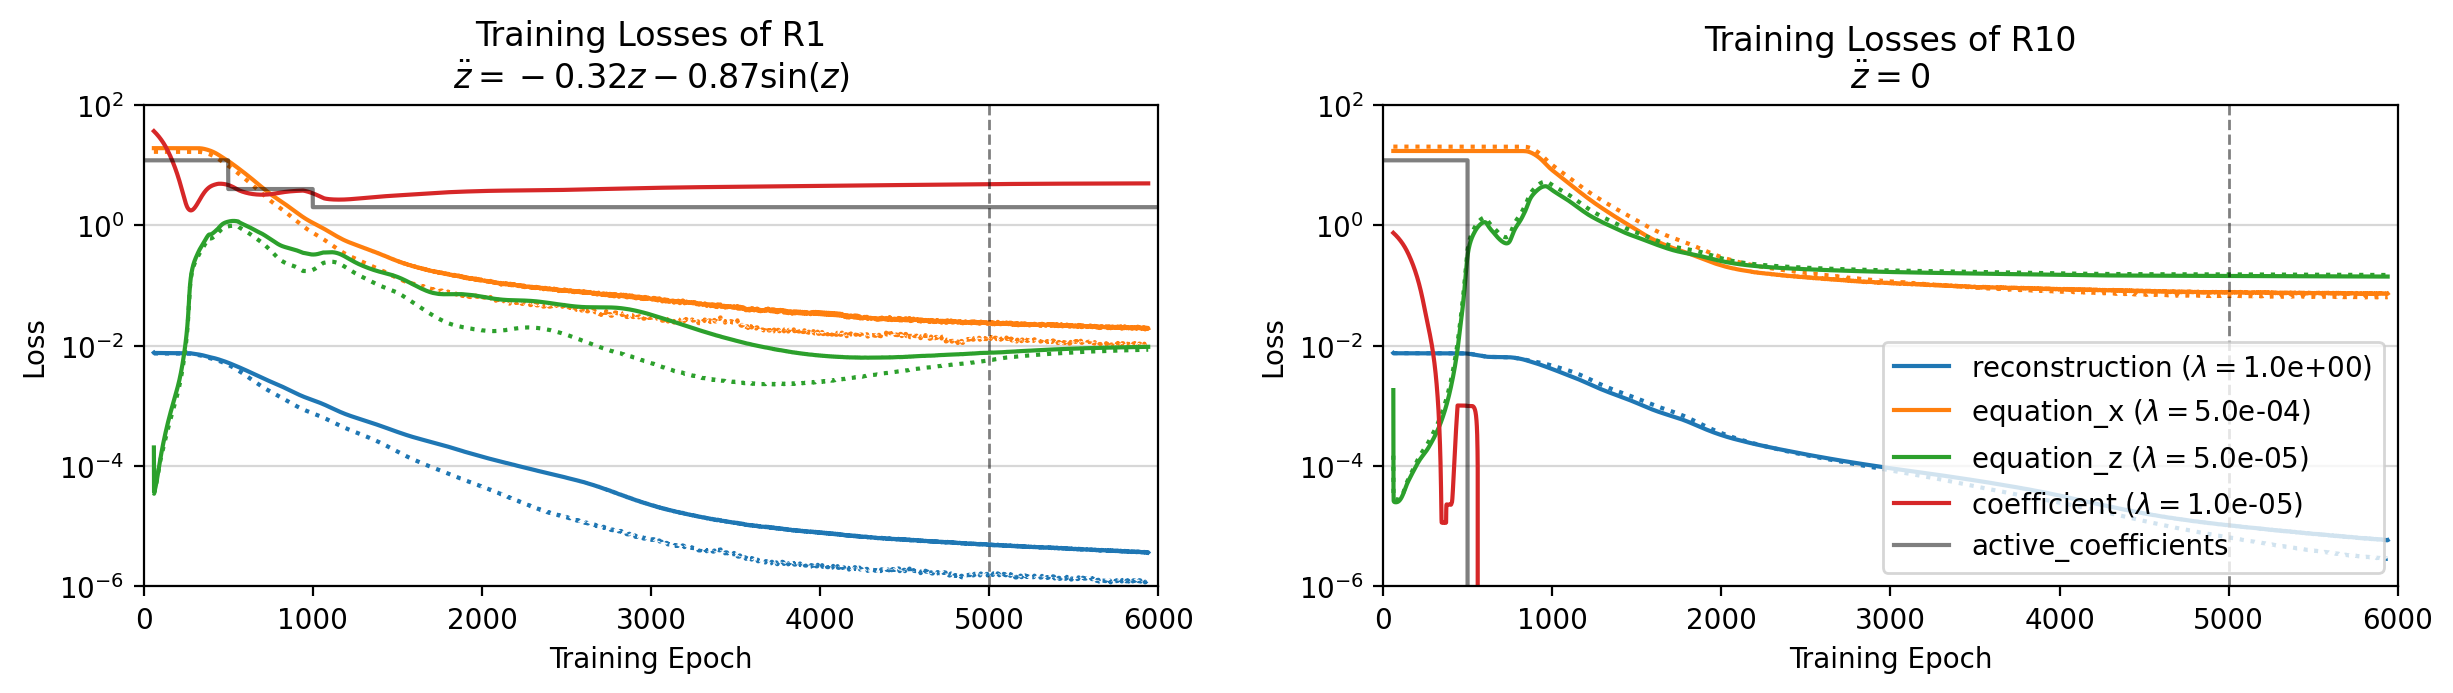

In [47]:
selection = [0, 9]
selection_equations = [r'$\ddot z = -0.32z - 0.87 \sin(z)$', r'$\ddot z = 0$']

fig, axes = plt.subplots(1, 2, figsize=(12, 3), dpi=200)
fig.tight_layout(w_pad=5)

smooth_lengthscale = (6000 // 50)
t = np.arange(6000)[smooth_lengthscale//2: -smooth_lengthscale//2+1]
refinement_beginning_epoch = 5000

for ax, i, equation in zip(axes, selection, selection_equations):
    model_name = model_names[i]

    for k, c in zip(['reconstruction', 'equation_x', 'equation_z'], named_colors):
        v = model_loss_history[model_name].item()[k]
        ax.plot(t, np.convolve(v, np.ones(smooth_lengthscale), 'valid') / smooth_lengthscale, label=k + r' ($\lambda = $' + '{:.1e})'.format(model_loss_weights[model_name][k]), color=c)
        v = model_loss_history[model_name].item()['val_' + k]
        ax.plot(t, np.convolve(v, np.ones(smooth_lengthscale), 'valid') / smooth_lengthscale, color=c, linestyle=':')

    v = model_loss_history[model_name].item()['coefficient']
    ax.plot(t, np.convolve(v, np.ones(smooth_lengthscale), 'valid') / smooth_lengthscale, label='coefficient' + r' ($\lambda = $' + '{:.1e})'.format(model_loss_weights[model_name]['coefficient']), color='tab:red')

    v = model_loss_history[model_name].item()['active_coefficients']
    ax.plot(v, label='active_coefficients', color='black', alpha=0.5)

    ax.set_xlim(0, len(v)); ax.set_ylim(1e-6, 1e2); ax.axvline(refinement_beginning_epoch, color='black', linestyle='--', linewidth=1, alpha=0.5); ax.set_yscale('log');
    ax.grid(axis='y', alpha=0.5); ax.set_xlabel('Training Epoch'); ax.set_ylabel('Loss'); ax.set_title(f'Training Losses of R{i+1}\n' + equation);

    if i == 9: ax.legend();